In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_figlet.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_figlettest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.324094,0.006131,911.319040,49312.485831,0.010610,1355.186590,7327.460939,1.0,103.0,0.101562,6.0,65.278711,2.508814e+10,19.192693
1,0.435870,0.012711,12652.088889,99214.222222,0.010610,5997.000000,17316.288889,1.0,251.0,0.103955,6.0,65.278711,2.508814e+10,19.192693
2,0.468027,0.012978,12652.088889,101398.755556,0.033712,8108.177778,21682.377778,1.0,396.0,0.106485,6.0,11.526728,2.508814e+10,19.333974
3,0.465293,0.014400,11832.888889,128341.333333,0.033712,9869.933333,22551.844444,1.0,542.0,0.105202,6.0,11.526728,2.508814e+10,19.333974
4,0.461566,0.010489,0.000000,90294.044444,0.037694,7584.933333,18696.533333,1.0,585.0,0.102712,6.0,11.493428,2.508814e+10,19.054890


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,2.624204,481.508966,0.101562,103.0
1,2.624204,481.508966,0.103955,251.0
2,0.463374,485.053440,0.106485,396.0
3,0.463374,485.053440,0.105202,542.0
4,0.462036,478.051738,0.102712,585.0


In [6]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests
3290,2.379505,572.538470,0.235285,18802.0
3291,2.332224,572.538470,0.235285,26274.0
3292,2.332224,572.065382,0.235285,33763.0
3293,2.324085,572.065382,0.326864,38767.0
3294,2.324085,572.486246,0.235285,33641.0


In [7]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [8]:
df_t.shape

(2579, 4)

In [9]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

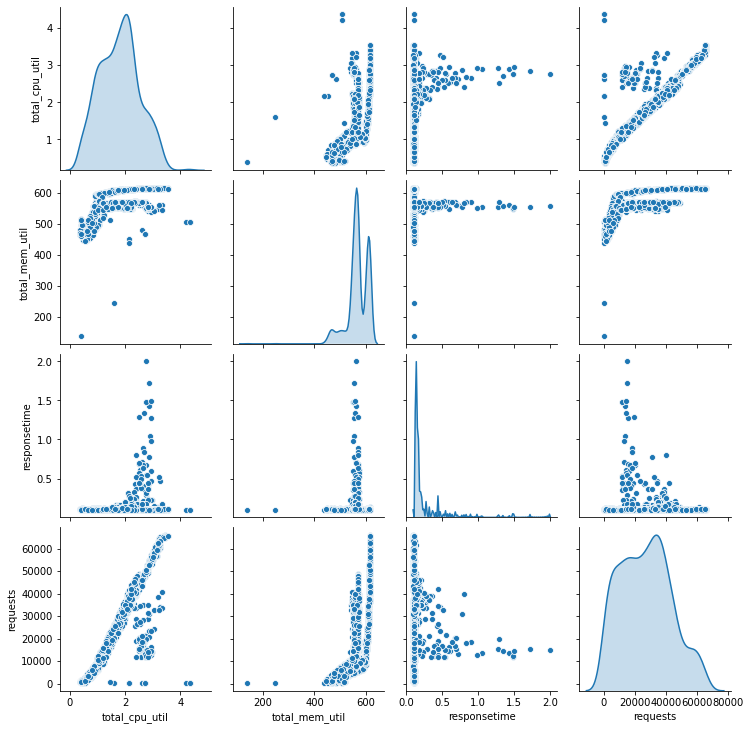

In [10]:
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,2063.0,1.802449,0.715306,0.369352,1.240840,1.819273,2.244835,4.363428
total_mem_util,2063.0,567.570779,39.498693,137.219482,552.863232,568.009114,604.695245,616.495718
responsetime,2063.0,0.129342,0.115991,0.099105,0.103883,0.107086,0.113091,1.999501
requests,2063.0,27122.444014,16215.375596,31.000000,13849.500000,26898.000000,38447.000000,66108.000000


In [12]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [13]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests
259,1.923371,568.192205,0.103361,34174.0
1301,2.717520,612.240998,0.114410,48274.0
3131,1.957293,570.568704,0.103025,32914.0
3063,1.669178,570.091930,0.105804,26452.0
518,0.877700,480.162816,0.106193,5186.0


In [14]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [15]:
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])

input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 28000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [requests]')
  plt.legend()
  plt.grid(True)
  return plt.show()

In [17]:
def plot_prediction(test_labels, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values requests')
    plt.ylabel('Predictions requests')
    lims = [0, 80000]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    return plt.show()

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0)
def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(1,name="dense_three")
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


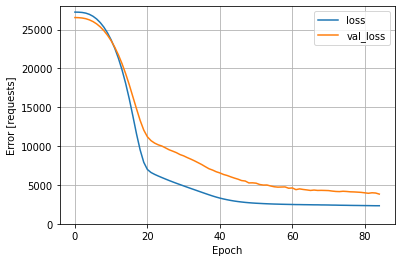

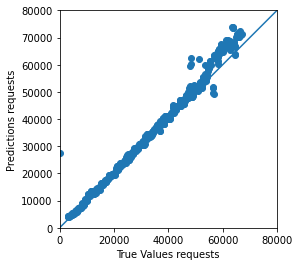

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


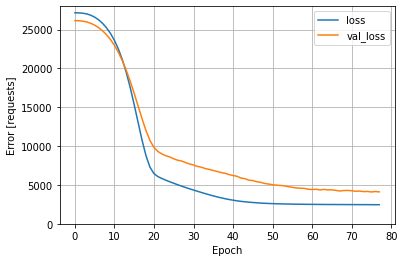

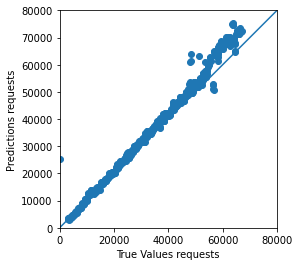

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


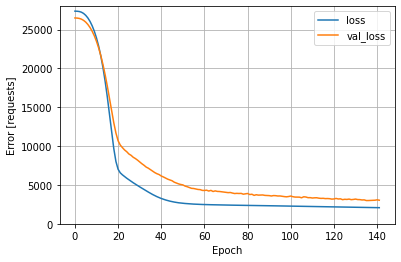

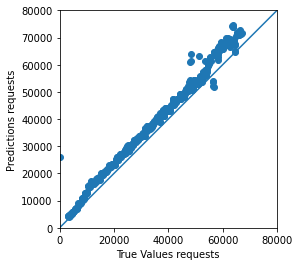

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


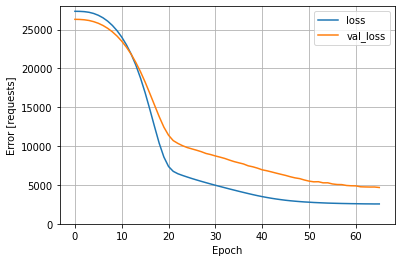

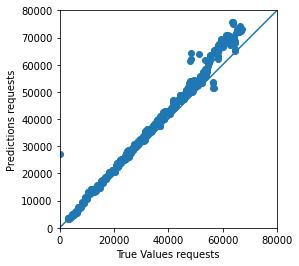

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


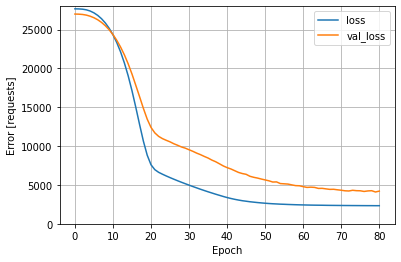

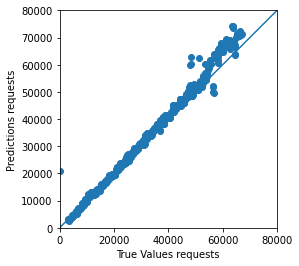

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


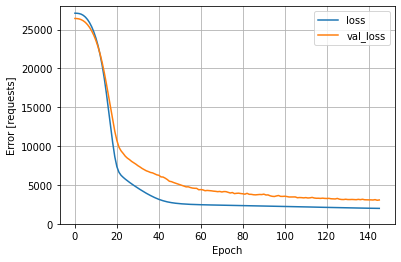

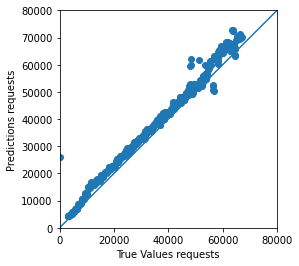

In [19]:
#%%time
i = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values
kf = KFold(n_splits=6, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer.adapt(input)

# Create Model
    dnn_model = None
    dnn_model = build_and_compile_model(input_normalizer)

    print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000,callbacks=[callback])
    #print(history)
    plot_loss(history)
    loss.append(dnn_model.evaluate(val_features, val_labels,verbose=0))
    ## Make Predictions
    test_predictions = dnn_model.predict(test_features).flatten()

    plot_prediction(test_labels, test_predictions)
    R = r2_score(test_labels, test_predictions)*100
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #test_results['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

In [21]:
data = np.array([model, loss, score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])

,model,loss,score
0,dnn_model_0,2548.18896484375,96.9869260439245
1,dnn_model_1,2860.173828125,95.63995321593872
2,dnn_model_2,2396.01708984375,93.50281794746799
3,dnn_model_3,2504.321533203125,94.58735183687278
4,dnn_model_4,3176.689208984375,96.93639643790576
5,dnn_model_5,2248.316650390625,95.77542651544981


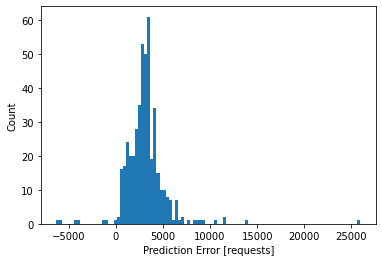

In [22]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')